In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from training_utils import *

# import training_utils
# importlib.reload(training_utils)
# from training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a few different labels and study how they affect the generated emebdding space. For now, we focus *povo* and *categoria*.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open(row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, _ = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [03:03<00:00,  7.96s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits = self.classifier(embeddings)
        return logits

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

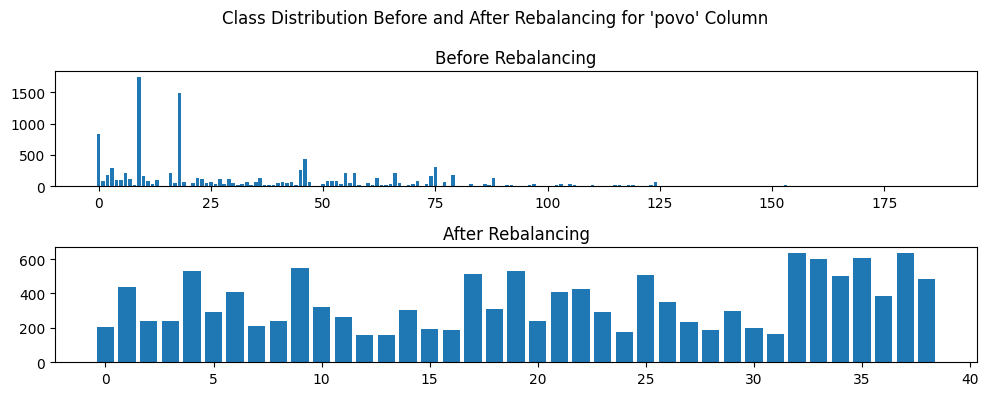

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

In [ ]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['povo'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   3%|█▌                                           | 1/30 [04:12<2:01:50, 252.10s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1052.3245, Validation Accuracy: 0.3506


Training model:   7%|███                                          | 2/30 [08:22<1:57:07, 250.99s/it]

Best model saved at epoch 2
Epoch 2, Loss: 773.5323, Validation Accuracy: 0.4524


Training model:  10%|████▌                                        | 3/30 [12:32<1:52:47, 250.64s/it]

Best model saved at epoch 3
Epoch 3, Loss: 591.9057, Validation Accuracy: 0.5194


Training model:  13%|██████                                       | 4/30 [16:42<1:48:34, 250.57s/it]

Best model saved at epoch 4
Epoch 4, Loss: 441.8979, Validation Accuracy: 0.5614


Training model:  17%|███████▌                                     | 5/30 [20:52<1:44:12, 250.09s/it]

Best model saved at epoch 5
Epoch 5, Loss: 314.5892, Validation Accuracy: 0.6021


Training model:  20%|█████████                                    | 6/30 [25:03<1:40:09, 250.42s/it]

Best model saved at epoch 6
Epoch 6, Loss: 215.8942, Validation Accuracy: 0.6244


Training model:  23%|██████████▌                                  | 7/30 [29:09<1:35:24, 248.90s/it]

Best model saved at epoch 7
Epoch 7, Loss: 148.6648, Validation Accuracy: 0.6356


Training model:  27%|████████████                                 | 8/30 [33:15<1:30:55, 247.98s/it]

Best model saved at epoch 8
Epoch 8, Loss: 101.7361, Validation Accuracy: 0.6461


Training model:  30%|█████████████▌                               | 9/30 [37:26<1:27:10, 249.08s/it]

Epoch 9, Loss: 65.8067, Validation Accuracy: 0.6435


Training model:  33%|██████████████▋                             | 10/30 [41:35<1:22:57, 248.89s/it]

Epoch 10, Loss: 45.2774, Validation Accuracy: 0.6408


Training model:  37%|████████████████▏                           | 11/30 [45:41<1:18:36, 248.26s/it]

Epoch 11, Loss: 42.2243, Validation Accuracy: 0.6461


In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 30
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 30
num_classes = len(povo_filtered_categories)
freeze = 8
model = ViTClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [ ]:
# Now rebalancing the 'categoria' column
categoria_labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

In [ ]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

In [ ]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [ ]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

In [ ]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['categoria'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categoris, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 30
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = len(categoria_filtered_categories)
freeze = 8
model = ViTClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

In [ ]:
# Utility function to plot rows on projection comparison plot
def row_plot(projs, proj_names, row, color, rows=3, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_plot(projs, proj_names, 2, 'g')

# LATER DECIDE IF I WANT TO PLOT FROZEN MODELS' PROJECTIONS DEPENDING ON PERFORMANCE

plt.tight_layout()
plt.show()

### Visualizing Clusters

In [ ]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

In [ ]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

In [ ]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

## DINOv2

### Pre-Trained Embedding Space

In [ ]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, _ = get_embeddings(model, povo_dataloader, device, model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

### Fine-Tuning Embedding Space

In [ ]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier = nn.Linear(self.dino.config.hidden_size, num_classes)
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits = self.classifier(embeddings)
        return logits

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [ ]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 30
num_classes = ind_df['povo'].nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, tes_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categoris, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 30
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = len(povo_filtered_categories)
freeze = 8
model = DINOClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [ ]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 30
num_classes = ind_df['categoria'].nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categoris, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 30
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = len(categoria_filtered_categories)
freeze = 8
model = DINOClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT"]
row_plot(projs, proj_names, 1, 'b', 2, 3)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO"]
row_plot(projs, proj_names, 2, 'r', 2, 3)

plt.tight_layout()
plt.show()